In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%store -r final_draftDB
%store -r draft_db

In [3]:
print(final_draftDB.shape)
print(draft_db.shape)

(1512, 15)
(1512, 27)


In [4]:
draft_db = draft_db.reset_index()
draft_db = draft_db.drop(['index'], axis=1)
draft_db.head()

,Overall,Team,Player,Nat.,Pos,Age,To,Junior Team,League,GP,...,D0_GP,D0_G,D0_A,D0_TP,D0_P/G,D0_PIM,D0_+/-,NHLe Coefficient,NHLe,NHLer
0,1,Chicago Blackhawks,Patrick Kane,US,RW,18.0,2023.0,London Knights,OHL,1126.0,...,58,62,83,145,2.50,52,42.0,0.144,29.52000,1.0
1,2,Philadelphia Flyers,James van Riemsdyk,US,LW,18.0,2023.0,USA U-18 Development Team,USDP/NAHL,885.0,...,30,20,18,38,1.27,44,0.0,0.121,12.60094,1.0
2,3,Phoenix Coyotes,Kyle Turris,CA,C,18.0,2022.0,Burnaby,BCHL,776.0,...,53,66,55,121,2.28,83,0.0,0.080,14.95680,1.0
3,4,Los Angeles Kings,Thomas Hickey,CA,D,18.0,2022.0,Seattle Thunderbirds,WHL,456.0,...,68,9,41,50,0.74,70,15.0,0.141,8.55588,1.0
4,5,Washington Capitals,Karl Alzner,CA,D,18.0,2020.0,Calgary Hitmen,WHL,686.0,...,63,8,39,47,0.75,32,16.0,0.141,8.67150,1.0


In [5]:
# Create a total games played column in the final draft dataframe

final_draftDB['GP'] = draft_db['GP']

In [6]:
final_draftDB.head()

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP
0,1,Chicago Blackhawks,Patrick Kane,RW,18.0,177.80,178.0,43.0,58.0,101.0,11.27172,29.52000,40.79172,18.24828,1.0,1126.0
1,2,Philadelphia Flyers,James van Riemsdyk,LW,18.0,190.50,200.0,32.0,30.0,62.0,3.78102,12.60094,16.38196,8.81992,1.0,885.0
2,3,Phoenix Coyotes,Kyle Turris,C,18.0,185.42,185.0,57.0,53.0,110.0,8.26560,14.95680,23.22240,6.69120,1.0,776.0
3,4,Los Angeles Kings,Thomas Hickey,D,18.0,180.34,184.0,69.0,68.0,137.0,4.74042,8.55588,13.29630,3.81546,1.0,456.0
4,5,Washington Capitals,Karl Alzner,D,18.0,190.50,206.0,70.0,63.0,133.0,3.93108,8.67150,12.60258,4.74042,1.0,686.0


In [7]:
%store final_draftDB

Stored 'final_draftDB' (DataFrame)


In [123]:
# Check for missing values
final_draftDB.isnull().sum()

Overall               0
Team                  0
Player                0
Pos                   0
Age                   0
Height                0
Weight                0
D-1_GP                0
D0_GP                 0
Total GP              0
D-1_NHLe              0
D0_NHLe               0
NHLe Total            0
NHLe Progression      0
NHLer                 0
GP                  726
dtype: int64

In [124]:
# Impute missing GP values with 0 as the players without them did not make the NHL

final_draftDB['GP'] = final_draftDB['GP'].fillna(0)

In [190]:
GP_0 = final_draftDB[final_draftDB['GP'] == 0][0:10]
GP_1 = final_draftDB.loc[(final_draftDB['GP'] >= 10) & (final_draftDB['GP'] <50)][0:20]
GP_2 = final_draftDB.loc[(final_draftDB['GP'] >= 50) & (final_draftDB['GP'] <100)][0:30]
GP_3 = final_draftDB.loc[(final_draftDB['GP'] >= 100) & (final_draftDB['GP'] < 200)][0:130]
GP_4 = final_draftDB.loc[(final_draftDB['GP'] >= 200) & (final_draftDB['GP'] < 400)][0:130]
GP_5 = final_draftDB.loc[(final_draftDB['GP'] >= 400) & (final_draftDB['GP'] < 600)]
GP_6 = final_draftDB.loc[final_draftDB['GP'] > 600]

In [191]:
resampled = [GP_0, GP_1, GP_2, GP_3, GP_4, GP_5, GP_6]

resampled_df = pd.concat(resampled, axis=0)

<AxesSubplot: xlabel='GP', ylabel='Count'>

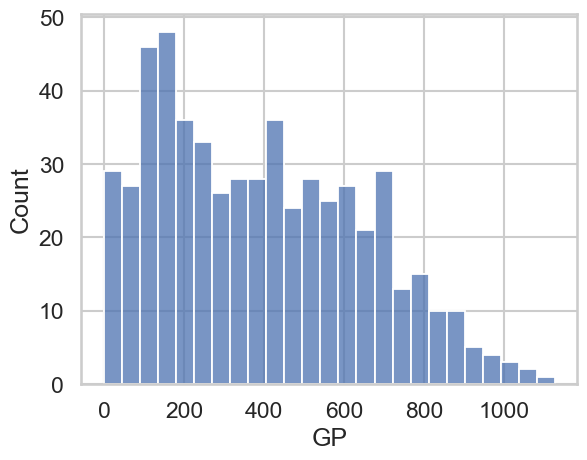

In [192]:
sns.histplot(x=resampled_df['GP'], bins=25)

In [195]:
resampled_df['NHLer'].value_counts()

1.0    388
0.0    166
Name: NHLer, dtype: int64

## Select GP as target variable for regression modelling

In [197]:
x_db = resampled_df.drop(['Overall', 'Team', 'Player', 'NHLer', 'GP'], axis=1)

y_db = resampled_df['GP']

## Train Test Split

In [200]:
from sklearn.model_selection import train_test_split

In [44]:
# Divide target variable by its max number for scaling purposes
y_db = y_db.divide(1126)

In [129]:
X_train = x_db.loc[0:1132]
X_test = x_db.loc[1133:1512]
y_train = y_db.loc[:1132]
y_test = y_db.loc[1133:1512]

In [201]:
X_train, X_test, y_train, y_test = train_test_split(x_db, y_db, test_size=0.25, random_state=42)

## Pipeline

In [216]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

### One hot encoder

In [217]:
ohe = OneHotEncoder(sparse=False)

### PCA

In [218]:
# Select number of principle components
pca = PCA(n_components=1)

### Select Kbest

In [219]:
# Instantiate SelectKBest Variable
selection = SelectKBest(k=6)

### Instantiating Standard Scaler

In [220]:
scaler=StandardScaler()

### Instantiating XGBoost model

In [221]:
from sklearn.ensemble import GradientBoostingRegressor

In [240]:
Gb_clf = GradientBoostingRegressor(learning_rate=0.001, max_depth=3, n_estimators=250)

## Set up Pipeline

In [241]:
# define individual transformers in a pipeline

categorical_preprocessing = Pipeline([('ohe', OneHotEncoder(sparse=False)),
                                           ('PCA', pca)])

numerical_preprocessing = Pipeline([('scale', StandardScaler()),
                                         ('selectK_best', selection)])

In [242]:
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['Pos']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age', 'Height', 'Weight',
                                                          'D-1_GP', 'D0_GP',
                                                          'Total GP', 'D-1_NHLe',
                                                          'D0_NHLe', 'NHLe Total',
                                                          'NHLe Progression'
                                                         ])
])
    
preprocess

ColumnTransformer(transformers=[('categorical_preprocessing',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(sparse=False)),
                                                 ('PCA', PCA(n_components=1))]),
                                 ['Pos']),
                                ('numerical_preprocessing',
                                 Pipeline(steps=[('scale', StandardScaler()),
                                                 ('selectK_best',
                                                  SelectKBest(k=6))]),
                                 ['Age', 'Height', 'Weight', 'D-1_GP', 'D0_GP',
                                  'Total GP', 'D-1_NHLe', 'D0_NHLe',
                                  'NHLe Total', 'NHLe Progression'])])

In [243]:
# create the final pipeline with preprocessing steps and 
# the final classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('best_model', Gb_clf)
])

pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False)),
                                                                  ('PCA',
                                                                   PCA(n_components=1))]),
                                                  ['Pos']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('selectK_best',
                                                                   SelectKBest(k=6))]),
                                                  ['Age', 'Height', 'Weight',
                                                   'D-1_GP', 'D0_GP',
                                                   'Total GP', 'D-1_NHLe',
                                                   'D0_NHLe', 'NHLe Total',
                                                   'NHLe Progression'])])),
                ('best_model',
                 GradientBoostingRegressor(learning_rate=0.001,
                                           n_estimators=250))])

In [244]:
print(X_train.shape)
print(y_train.shape)

(415, 11)
(415,)


/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_2956/3981937693.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, kde=True)


<AxesSubplot: xlabel='GP', ylabel='Density'>

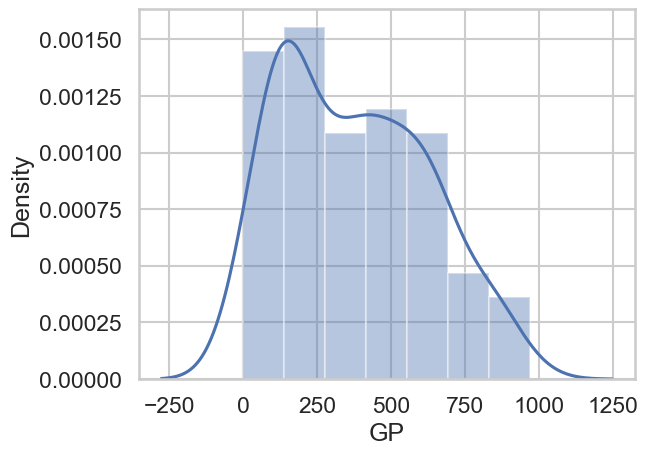

In [245]:
sns.distplot(y_test, kde=True)

In [246]:
# Call the pipeline on the training data

xgb_model = pipeline.fit(X_train, y_train)

In [247]:
xgb_model.score(X_test, y_test)

0.026329223133126467

In [248]:
feat_names = pipeline.steps[0][1].get_feature_names_out()
feat_import = pipeline.steps[1][1].feature_importances_

<AxesSubplot: >

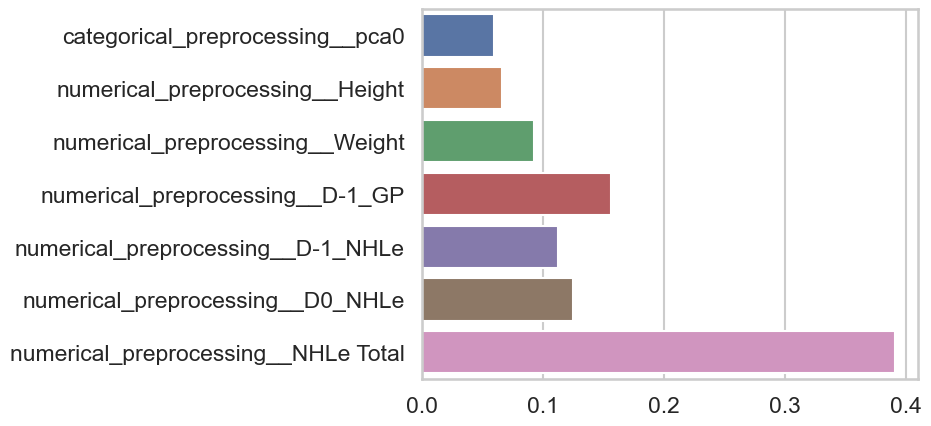

In [249]:
sns.set_theme(style='whitegrid', context='talk')

sns.set_color_codes('pastel')
sns.barplot(x=feat_import, y=feat_names)

In [253]:
arr = xgb_model.predict(X_test)

### Using GridSearch to improve model performance

In [251]:
from sklearn.model_selection import GridSearchCV

In [252]:
param_grid = [
    {
        'best_model__learning_rate': [0.001, 0.01, 0.1, 1.0],
        'best_model__n_estimators': [10, 100, 250],
        'best_model__max_depth': [3, 4, 5]
    }
]

In [237]:
gridSearch = GridSearchCV(xgb_model, param_grid=param_grid, n_jobs=-1, verbose=3)
gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(sparse=False)),
                                                                                         ('PCA',
                                                                                          PCA(n_components=1))]),
                                                                         ['Pos']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('selectK_best',
                                                                                          SelectKBest(k=6))]),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'D-1_GP',
                                                                          'D0_GP',
                                                                          'Total '
                                                                          'GP',
                                                                          'D-1_NHLe',
                                                                          'D0_NHLe',
                                                                          'NHLe '
                                                                          'Total',
                                                                          'NHLe '
                                                                          'Progression'])])),
                                       ('best_model',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'best_model__learning_rate': [0.001, 0.01, 0.1, 1.0],
                          'best_model__max_depth': [3, 4, 5],
                          'best_model__n_estimators': [10, 100, 250]}],
             verbose=3)

In [238]:
print('Final score is: ', gridSearch.score(X_test, y_test))

Final score is:  0.026355694691961973


In [239]:
gridSearch.best_params_

{'best_model__learning_rate': 0.001,
 'best_model__max_depth': 3,
 'best_model__n_estimators': 250}

### Taking a look at the results

In [254]:
overall_reg = []

for i in arr:
    overall_reg.append(i)

In [260]:
overall = pd.DataFrame(overall_reg)

X_test['GP_reg'] = overall.iloc[:,0].values

X_test.drop(['Overall_reg'], axis=1, inplace=True)

In [261]:
X_test

,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,GP_reg
299,C,18.0,177.80,180.0,33.0,31.0,64.0,9.96710,11.37422,21.34132,1.40712,406.419214
265,LW,18.0,180.34,188.0,55.0,71.0,126.0,2.54364,6.70596,9.24960,4.16232,388.295665
1244,D,18.0,175.26,191.0,56.0,67.0,123.0,4.20906,5.45710,9.66616,1.24804,388.295665
210,C,18.0,182.88,185.0,66.0,70.0,136.0,9.59646,12.37134,21.96780,2.77488,433.237079
1508,RW,18.0,182.88,172.0,50.0,49.0,99.0,2.45344,3.59652,6.04996,1.14308,388.295665
...,...,...,...,...,...,...,...,...,...,...,...,...
1327,LW,18.0,185.42,182.0,63.0,67.0,130.0,8.97408,16.76736,25.74144,7.79328,429.958500
642,RW,18.0,154.94,191.0,42.0,66.0,108.0,2.56824,7.83838,10.40662,5.27014,392.057201
588,D,18.0,182.88,170.0,61.0,48.0,109.0,3.81546,5.78100,9.59646,1.96554,388.295665
1162,RW,18.0,180.34,181.0,59.0,56.0,115.0,4.92246,12.63456,17.55702,7.71210,392.024770


[CV 3/5] END best_model__learning_rate=0.001, best_model__max_depth=3, best_model__n_estimators=10;, score=-0.006 total time=   0.1s
[CV 5/5] END best_model__learning_rate=0.001, best_model__max_depth=3, best_model__n_estimators=10;, score=-0.005 total time=   0.1s
[CV 4/5] END best_model__learning_rate=0.001, best_model__max_depth=3, best_model__n_estimators=100;, score=-0.007 total time=   0.2s
[CV 3/5] END best_model__learning_rate=0.001, best_model__max_depth=3, best_model__n_estimators=250;, score=-0.006 total time=   0.3s
[CV 2/5] END best_model__learning_rate=0.001, best_model__max_depth=4, best_model__n_estimators=10;, score=-0.001 total time=   0.1s
[CV 4/5] END best_model__learning_rate=0.001, best_model__max_depth=4, best_model__n_estimators=10;, score=-0.005 total time=   0.1s
[CV 2/5] END best_model__learning_rate=0.001, best_model__max_depth=4, best_model__n_estimators=100;, score=0.004 total time=   0.2s
[CV 5/5] END best_model__learning_rate=0.001, best_model__max_depth